# xcube GEDI Data Store

This notebook provides a walk-through demonstrating how to use the xcube-gedi plugin to read and explore data from the GEDI API using the `gedidb` pacakge.

In [1]:
from xcube_gedi.store import GediDataStore

In [2]:
import xcube_gedi
xcube_gedi.__version__

'0.1.0.dev'

In [3]:
gedi = GediDataStore()

In [4]:
gedi.get_open_data_params_schema()

In [5]:
gedi.get_available_variables()

,description,dtype,product_level,units,profile_length
agbd,Aboveground biomass density,float32,L4A,Mg/ha,NaN
agbd_pi_lower,Lower prediction interval for aboveground biom...,float32,L4A,Mg/ha,NaN
agbd_pi_upper,Upper prediction interval for aboveground biom...,float32,L4A,Mg/ha,NaN
agbd_se,Standard error of aboveground biomass density,float32,L4A,Mg/ha,NaN
agbd_t,Model prediction in fit units,float32,L4A,adimensional,NaN
...,...,...,...,...,...
wsci_xy_pi_upper,Horizontal Structural Complexity upper predict...,float32,L4C,adimensional,NaN
wsci_z,Vertical Structural Complexity,float32,L4C,adimensional,NaN
wsci_z_pi_lower,Vertical Structural Complexity lower predictio...,float32,L4C,adimensional,NaN
wsci_z_pi_upper,Vertical Structural Complexity upper predictio...,float32,L4C,adimensional,NaN


In [6]:
gedi.get_available_variables(product_level = "L4A")

,description,dtype,product_level,units,profile_length
agbd,Aboveground biomass density,float32,L4A,Mg/ha,NaN
agbd_pi_lower,Lower prediction interval for aboveground biom...,float32,L4A,Mg/ha,NaN
agbd_pi_upper,Upper prediction interval for aboveground biom...,float32,L4A,Mg/ha,NaN
agbd_se,Standard error of aboveground biomass density,float32,L4A,Mg/ha,NaN
agbd_t,Model prediction in fit units,float32,L4A,adimensional,NaN
agbd_t_se,Model prediction standard error in fit units,float32,L4A,adimensional,NaN
l2_quality_flag,Flag identifying the most useful L2 data for b...,uint8,L4A,adimensional,NaN
l4_quality_flag,Flag simplifying selection of most useful biom...,uint8,L4A,adimensional,NaN
predict_stratum,Prediction stratum name for the 1 km cell,U20,L4A,adimensional,NaN
predictor_limit_flag,"Prediction stratum identifier (0=in bounds, 1=...",uint8,L4A,adimensional,NaN


In [12]:
%%time

bbox = (30.256673359035123, -15.85375449790373, 30.422423359035125, -15.62525449790373)
vars_selected = ["agbd", "rh"]
start_time = "2023-01-01"
end_time = "2024-07-02"

gedi_data = gedi.open_data(
    variables=vars_selected,
    query_type="bounding_box",
    bbox=bbox,
    start_time=start_time,
    end_time=end_time,
    return_type='xarray'
)

CPU times: user 3.84 s, sys: 13.5 s, total: 17.4 s
Wall time: 17.3 s


In [13]:
gedi_data

<xarray.Dataset> Size: 1MB
Dimensions:         (shot_number: 2492, profile_points: 101)
Coordinates:
  * shot_number     (shot_number) uint64 20kB 234630100400367828 ... 23463000...
  * profile_points  (profile_points) int64 808B 0 1 2 3 4 5 ... 96 97 98 99 100
    latitude        (shot_number) float64 20kB -15.8 -15.8 ... -15.75 -15.75
    longitude       (shot_number) float64 20kB 30.34 30.34 30.34 ... 30.31 30.31
    time            (shot_number) datetime64[ns] 20kB 2023-02-02 ... 2023-02-02
Data variables:
    agbd            (shot_number) float32 10kB 11.37 40.87 7.68 ... 119.5 149.7
    rh              (shot_number, profile_points) float32 1MB -6.06 ... 21.87

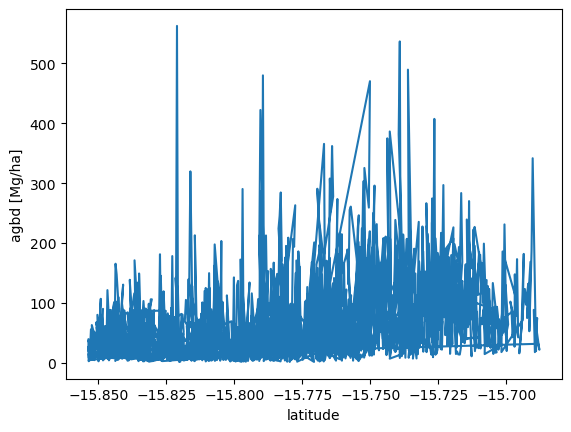

In [14]:
gedi_data.agbd.plot(x='latitude')

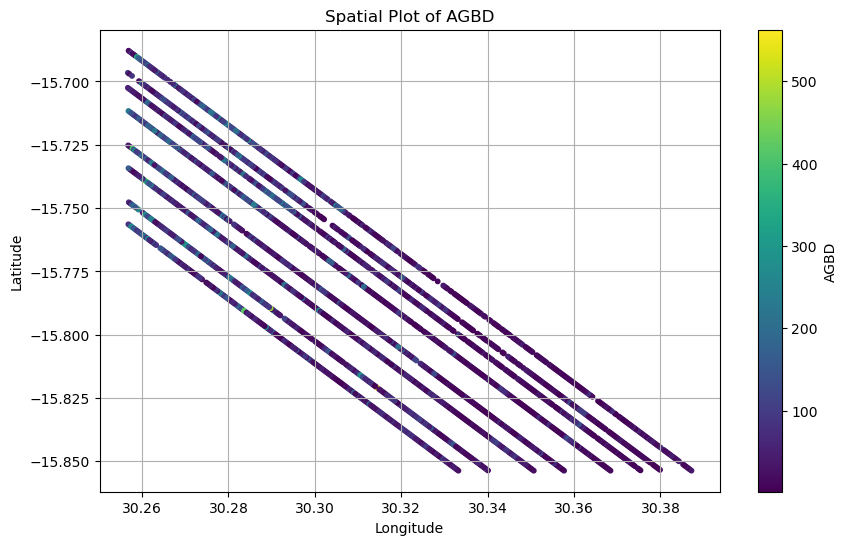

In [15]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['agbd'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='AGBD')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of AGBD')
plt.grid(True)
plt.show()

In [4]:
%%time
point=(8.948581, 50.716982)
num_shots=10
radius=0.1
query_type="nearest"
vars_selected = ["agbd", "rh"]
start_time = "2023-01-01"
end_time = "2024-07-02"

gedi_data = gedi.open_data(
    variables=vars_selected,
    point=point,
    query_type=query_type,
    start_time=start_time,
    end_time=end_time,
    return_type='xarray',
    num_shots=10,
    radius=0.1
)

CPU times: user 5.62 s, sys: 20.8 s, total: 26.4 s
Wall time: 23.7 s


In [5]:
gedi_data

<xarray.Dataset> Size: 5kB
Dimensions:         (shot_number: 10, profile_points: 101)
Coordinates:
  * shot_number     (shot_number) uint64 80B 234911100300153462 ... 234911100...
  * profile_points  (profile_points) int64 808B 0 1 2 3 4 5 ... 96 97 98 99 100
    latitude        (shot_number) float64 80B 50.72 50.72 50.72 ... 50.72 50.72
    longitude       (shot_number) float64 80B 8.948 8.947 8.947 ... 8.951 8.952
    time            (shot_number) datetime64[ns] 80B 2023-02-04 ... 2023-02-04
Data variables:
    agbd            (shot_number) float32 40B 53.25 28.39 27.66 ... 144.3 176.3
    rh              (shot_number, profile_points) float32 4kB -3.85 ... 24.91

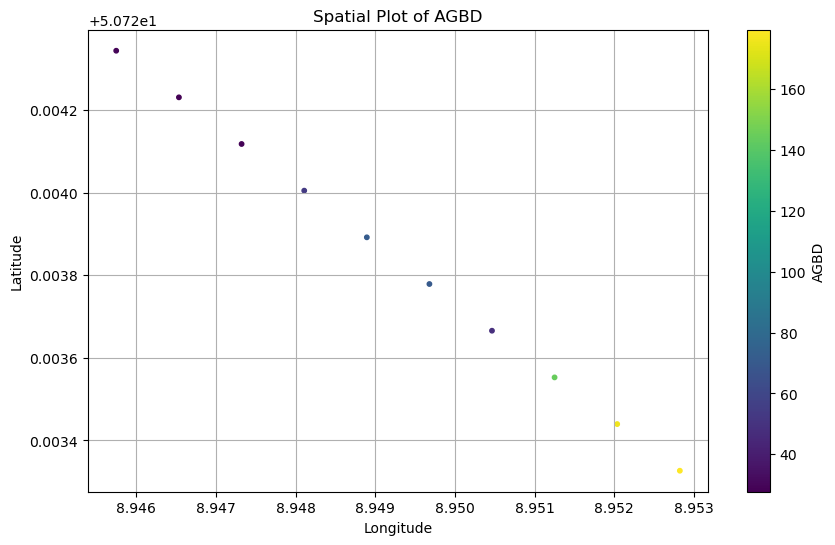

In [9]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['agbd'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='AGBD')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of AGBD')
plt.grid(True)
plt.show()